In [1]:
import warnings
warnings.filterwarnings('ignore')

import radiomics 
from radiomics import featureextractor
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from tabulate import tabulate
from statsmodels.stats.multitest import multipletests
from scipy.stats import f_oneway

# Performing Functions From Pipeline
This notebook walks through the various functions in the *data_pipeline.py* file.

## Apply Mask Prediction Models on all Subjects
Use this function to apply both the disc and vertebra model to all subjects. If not using this on Rosie, you will need to go into the apply_model_all function and change the directory paths.

In [2]:
from data_pipeline import apply_model_all

# where do you want all of the files to be stored?
create_directories_path = '/home/gibsont/cs3310/all_subject_predictions'
file_path_spine_data = '/home/gibsont/cs3310/Spine_data.csv'
create_plots = True 
show_plots = False # if you set this to false, the below function will run faster as the plots are not displayed

apply_model_all(create_directories_path, create_plots, show_plots, file_path_spine_data)

2023-05-14 22:17:42.726270: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 22:17:42.767272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 22:17:48.767738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-14 22:17:48.767820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: dh-node3
2023-05-14 22:17:48.767837: I tensorflow/

1/1 [==============================] - 2s 2s/step
S269 does not contain a vois folder. Skipping subject
1/1 [==============================] - 2s 2s/step
Path to T1/T2 file does not exist for S200. Skipping subject
1/1 [==============================] - 3s 3s/step
S206 has invalid count for initial estimate for discs. Skipping subject
S208 has invalid count for initial estimate for discs. Skipping subject
S209 has invalid count for initial estimate for discs. Skipping subject
S211 has invalid count for initial estimate for discs. Skipping subject
S212 has invalid count for initial estimate for discs. Skipping subject
1/1 [==============================] - 2s 2s/step
S215 has invalid count for initial estimate for discs. Skipping subject
1/1 [==============================] - 2s 2s/step
S217 has invalid count for initial estimate for discs. Skipping subject
S219 has invalid count for initial estimate for discs. Skipping subject
S220 has invalid count for initial estimate for discs. Skip

#### NOTES for given T2 files:
- S269 does not have a vois folder
- S200 does have proper T2 image (S200_T2.nii.gz) recheck
- S206 has invalid count for initial estimate for discs
- S208 has invalid count for initial estimate for discs
- S209 has invalid count for initial estimate for discs
- S211 has invalid count for initial estimate for discs
- S212 has invalid count for initial estimate for discs
- S215 has invalid count for initial estimate for discs
- S217 has invalid count for initial estimate for discs
- S219 has invalid count for initial estimate for discs
- S220 has 6 discs for initial estimate for discs
- S229 no vois folder
- S234 has different named vois folders

## Signal Intensity
Use this function to compare the discs of two subjects to see the frequency of the signal intensity.

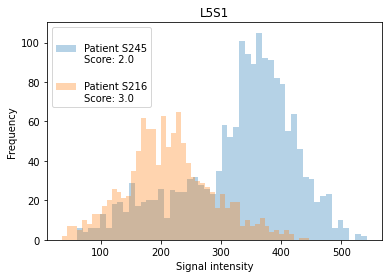

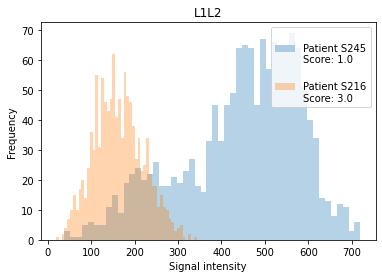

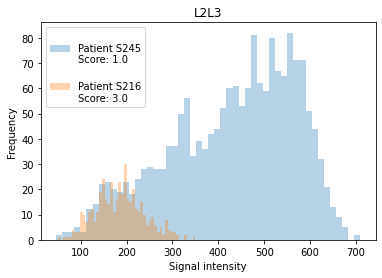

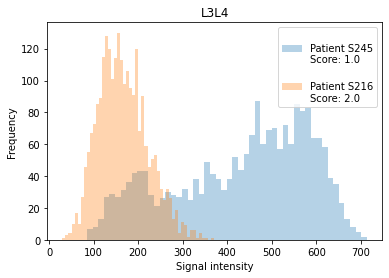

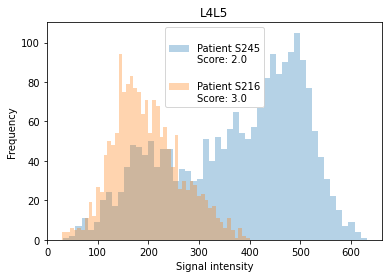

In [4]:
from data_pipeline import disc_signal_intensity

ts1 = 'S245' # healthy
ts1_datapath = '/data/cs3310/MuftulerLab1/data/spine/'
ts1_vois_path = f'/home/gibsont/cs3310/all_subject_predictions/{ts1}/'
ts2 = 'S216'
ts2_datapath = '/data/cs3310/MuftulerLab1/data/spine/'
ts2_vois_path = f'/home/gibsont/cs3310/all_subject_predictions/{ts2}/'
spine_data_path = '/home/gibsont/cs3310/Spine_data.csv'
save_hist_path = f'/home/gibsont/cs3310/all_subject_predictions/disc_signal_intensity/'
save_hist = False

dict_ts1, dict_ts2 = disc_signal_intensity(ts1=ts1,
                      ts1_datapath=ts1_datapath,
                      ts1_vois_path=ts1_vois_path,
                      ts2=ts2,
                      ts2_datapath=ts2_datapath,
                      ts2_vois_path=ts2_vois_path,
                      spine_data_path=spine_data_path,
                      save_hist_path=save_hist_path,
                      save_hist=save_hist
                     )

Use this function to compare the vertebras of two subjects to see the frequency of the signal intensity.

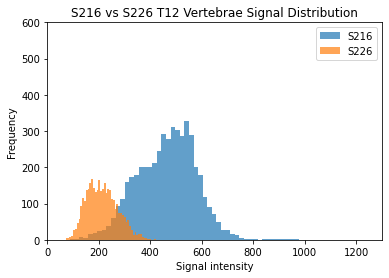

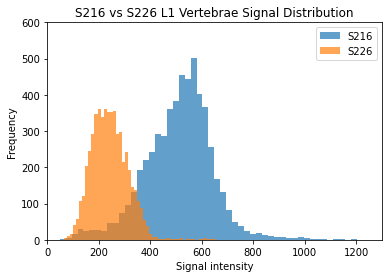

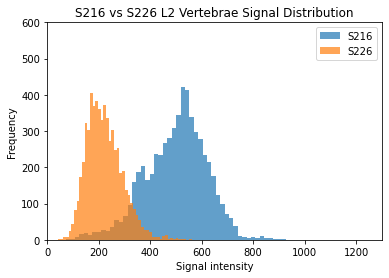

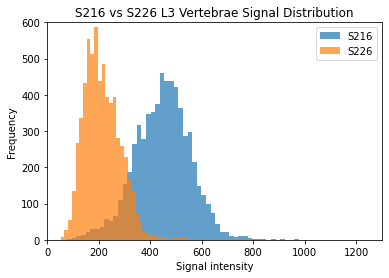

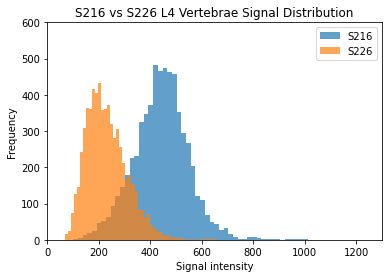

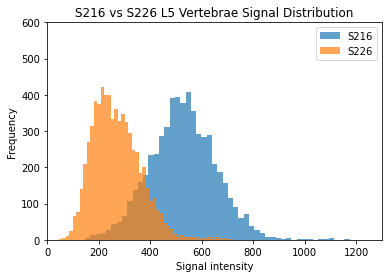

In [7]:
from data_pipeline import vertebra_signal_intensity

ts1 = 'S216'
ts1_datapath = '/data/cs3310/MuftulerLab1/data/spine/'
ts1_vois_path = f'/home/gibsont/cs3310/all_subject_predictions/{ts1}/'
ts2 = 'S226'
ts2_datapath = '/data/cs3310/MuftulerLab1/data/spine/'
ts2_vois_path = f'/home/gibsont/cs3310/all_subject_predictions/{ts2}/'
spine_data_path = '/home/gibsont/cs3310/Spine_data.csv'
save_hist_path = '/home/gibsont/cs3310/all_subject_predictions/'
save_hist = False

vertebra_signal_intensity(ts1=ts1,
                      ts1_datapath=ts1_datapath,
                      ts1_vois_path=ts1_vois_path,
                      ts2=ts2,
                      ts2_datapath=ts2_datapath,
                      ts2_vois_path=ts2_vois_path,
                      spine_data_path=spine_data_path,
                      save_hist_path=save_hist_path,
                      save_hist=save_hist
                     )

## Disc Radiomics
Finds the disc pyradiomcs features.

Paths to change:
- subjects_directory_path
- scan_path (might not need to change)
- path used in creation of pfirrman_df

In [8]:
from data_pipeline import get_disc_rad_features
from data_pipeline import get_vb_rad_features
from data_pipeline import get_subject_list

odi_df = pd.read_excel("/data/cs3310/MuftulerLab1/data/spine/spine_ODI_scores.xlsx")

In [11]:
# implementing feature extraction function to extract features of disc segments 
extractor = featureextractor.RadiomicsFeatureExtractor()

# get the test subjects based off of the where the prediciton files were created
subjects_directory_path = '/home/gibsont/cs3310/all_subject_predictions'
test_subjects = [name for name in os.listdir(subjects_directory_path) if os.path.isdir(os.path.join(subjects_directory_path, name))]

# create a dictionary with the key as the subject and values as a list of the radiomics features
subject_feat_dict = {}
for subject in test_subjects: 
    # get the scan path of the subject
    scan_path = f'/data/cs3310/MuftulerLab1/data/spine/{subject}/{subject.lower()}_T2.nii.gz'
    # get the prediction disc mask files of the subject
    disc_masks = [(subjects_directory_path + f'/{subject}/{subject}_L1L2.nii'),
                  (subjects_directory_path + f'/{subject}/{subject}_L2L3.nii'),
                  (subjects_directory_path + f'/{subject}/{subject}_L3L4.nii'),
                  (subjects_directory_path + f'/{subject}/{subject}_L4L5.nii'),
                  (subjects_directory_path + f'/{subject}/{subject}_L5S1.nii')]
    # get the radiomics features
    rad_feature = get_disc_rad_features(extractor, scan_path, disc_masks, subject)
    # add features to the dictionary
    subject_feat_dict[subject] = rad_feature
    
print('Number of subjects in dictionary', len(subject_feat_dict))

df = pd.DataFrame()
pfirrman_df = pd.read_csv("/home/gibsont/cs3310/Spine_data.csv")
frames = []

# loop through dictionary to create separate dataframes for each subject
for key in subject_feat_dict:
    df_subject = pd.DataFrame.from_dict(subject_feat_dict[key]).T
    df_subject = df_subject.rename(index={0: f"{key}_L1L2", 1: f"{key}_L2L3", 2: f"{key}_L3L4", 3: f"{key}_L4L5", 4: f"{key}_L5S1"})
    
    # add the ODI score to dataframe
    score = odi_df[odi_df['Subject_ID'] == int(key[1:])]
    score = score['Oswestry score  (ODI)'].tolist()[0]
    scores = [score for _ in range(5)]
    df_subject['Owestry score (ODI))'] = scores
    
    # add the pfirrman score to dataframe
    col_to_add = pfirrman_df[pfirrman_df[' Subject number '] == int(key[1:])]
    col_to_add = col_to_add['Pfirrman_degeneration_score'].tolist()
    df_subject['Pfirrman_degeneration_score'] = col_to_add
    frames.append(df_subject)
    
# merge the dataframes to create one dataframe
df_disc_radiomics = pd.concat(frames)
print('Shape of df:', df_disc_radiomics.shape)
df_disc_radiomics.head()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

ValueError: Error reading image Filepath or SimpleITK object

Save the dataframe as a csv file.

In [12]:
df_disc_radiomics.to_csv('data_radiomics_discs.csv', index=True)

NameError: name 'df_disc_radiomics' is not defined

## Looking further into the extracted Radiomics features
This will use Anova and Kruskal-Wallis Tests to further reduce the radiomics features.

In [ ]:
# import files of feature names from extracted PyRadiomics
radiomic_features = pd.read_csv('feature_names')

# import file containing compiled dataframe 
df = pd.read_csv('data_radiomics_discs.csv', index_col = 0)

# locating the second column where feature names are 
names=radiomic_features.iloc[:,1]
feat_names_ls=list(names)

# setting up columns for dataframe
feat_names= feat_names_ls + ['ODI','Pfirrman_degeneration_score']

# replacing column numbers to names of features from radiomics 
df.set_axis(feat_names,axis=1,inplace=True)

# dropping first order features 
first_order_feat = list(np.array(feat_names_ls)[['firstorder' in feature for feature in feat_names_ls]])
df = df.drop(first_order_feat, axis=1)

# removing first orders from name list
for feature in first_order_feat:
    feat_names_ls.remove(feature)
    
df['Pfirrman_degeneration_score'] = df['Pfirrman_degeneration_score'].astype('category')

**Kruskal-Wallis Test**

Null Hypothesis: all groups have the same medianAlternative 

Hypothesis: at least one group has a different median

In [ ]:
df_pyRadiomics = df[feat_names_ls+['Pfirrman_degeneration_score']]
#Getting category column
category = 'Pfirrman_degeneration_score'
categories = df[category].unique()

# Initializing a list to store resulting values of test
wallis_results = []

# Loop through each feature and perform the Kruskal-Wallis test
for feature_col in df_pyRadiomics.columns:
    if feature_col != category:
        groups = [df_pyRadiomics[df_pyRadiomics[category]==cat][feature_col] for cat in categories]
        h, p_val = kruskal(*groups)
        wallis_results.append([feature_col, h, p_val])

        
_, p_adjusted, _, alpha_corrected = multipletests([test[2] for test in wallis_results],method='bonferroni')
for x in range(len(p_adjusted)):
    wallis_results[x].append(p_adjusted[x])
    
# Find the significant features using Bonferroni-corrected alpha
significant_features = []
for i, test in enumerate(wallis_results):
    if p_adjusted[i] < alpha_corrected and test[1] > 0:
        significant_features.append(test[0])
        
significant_feature_willis = [test[0] for test in wallis_results if test[0] in significant_features]

**ANOVA Test**

Null Hypothesis: the means of all groups are the same

Alternative hypothesis: there is at least one group mean that is different then the others.

In [ ]:
# Initializing a list to store resulting values of test
anova_results = []

# Loop through each feature and perform the Kruskal-Wallis test
for feature_col in df_pyRadiomics.columns:
    if feature_col != category:
        groups = [df_pyRadiomics[df_pyRadiomics[category]==cat][feature_col] for cat in categories]
        f_stat, p_val = f_oneway(*groups)
        anova_results.append([feature_col, f_stat, p_val])

# Bonferroni implementation
_, p_adjusted, _, alpha_corrected = multipletests([test[2] for test in anova_results],method='bonferroni')
for x in range(len(p_adjusted)):
    anova_results[x].append(p_adjusted[x])
    
significant_features_anova = []
for i, test in enumerate(anova_results):
    if p_adjusted[i] < alpha_corrected and test[2] > 0:
        significant_features.append(test[0])
        
# Save the significant feature names in a list
significant_feature_anova = [test[0] for test in anova_results if test[0] in significant_features]

Getting the features in both Wallis and Anova

In [ ]:
significant_feat = []
for willis in significant_feature_willis:
    for anova in significant_feature_anova:
        if willis == anova:
            significant_feat.append(willis)

 Filtering out dataframe of all features to only include the ones that were found to be significant

In [ ]:
df_pyRadiomics = df_pyRadiomics[significant_feat]
df_pyRadiomics["ODI"] = df['ODI']
df_pyRadiomics['Pfirrman_degeneration_score'] = df['Pfirrman_degeneration_score']

Saving cleaned dataset.

In [ ]:
df_pyRadiomics.to_csv('data_radiomics_discs_fil.csv', index=True)

## LDA on Disc Extracted Features
This function will get the X and y training, validation, and testing sets based on LDA.

In [ ]:
from data_pipeline import lda_disc_extraction_features

filepath = 'data_radiomics_discs_fil.csv'
X_train, y_train, X_test, y_test, X_val, y_val = lda_disc_extraction_features(filepath)

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

## Run Classifier Models on the Disc Features
Make sure to run the LDA on Disc Extracted Features section before running this.

In [ ]:
from data_pipeline import run_disc_radiomic_classifier_models

classifier_models = run_disc_radiomic_classifier_models(X_train, y_train, X_test, y_test, X_val, y_val)

for model in classifier_models:
    print(f"Classifier: {model[0]}")
    print(f"Total accuracy: {model[1]}")
    print(f"Total MSE: {model[2]}")
    print(f"Per class accruacy: {model[3].diagonal()/model[3].sum(axis=1)}\n")

## Run Regression Models on the Disc Features
Make sure to run the LDA on Disc Extracted Features section before running this.

In [ ]:
from data_pipeline import run_disc_radiomic_regression_models

regression_models = run_disc_radiomic_regression_models(X_train, y_train, X_test, y_test, X_val, y_val)

for model in regression_models:
    print(f"Classifier {model[0]}")
    print(f"Total MSE is {model[1]}")
    print(f"Rounded MSE is {model[2]}\n")

## Radiomics Vertebra

Paths to change:
- subjects_directory_path
- scan_path (might not need to change)
- path used in creation of modic_df

In [ ]:
# implementing feature extraction function to extract features of vertebra segments 
vb_extractor = featureextractor.RadiomicsFeatureExtractor()

# get the test subjects based off of the where the prediciton files were created
subjects_directory_path = '/home/gibsont/cs3310/all_patients_predictions'
test_subjects = [name for name in os.listdir(subjects_directory_path) if os.path.isdir(os.path.join(subjects_directory_path, name))]

# create a dictionary with the key as the subject and values as a list of the radiomics features
subject_feat_dict = {}
for subject in test_subjects: 
    # get the scan path of the subject
    scan_path = f'/data/cs3310/MuftulerLab1/data/spine/{subject}/{subject.lower()}_T2.nii.gz'
    # get the prediction mask files for the subject
    vois = [    (subjects_directory_path + f'/{subject}/{subject}_L1_vb.nii'),
                (subjects_directory_path + f'/{subject}/{subject}_L2_vb.nii'),
                (subjects_directory_path + f'/{subject}/{subject}_L3_vb.nii'),
                (subjects_directory_path + f'/{subject}/{subject}_L4_vb.nii'),
                (subjects_directory_path + f'/{subject}/{subject}_L5_vb.nii')]
    
    # get the vertebra radiomic features
    rad_feature = get_vb_rad_features(vb_extractor, scan_path, vois)
    # add features to the dictionary
    subject_feat_dict[subject] = rad_feature
    
print('Number of subjects in dictionary', len(subject_feat_dict))
df = pd.DataFrame()
modic_df = pd.read_csv("/home/gibsont/cs3310/cleaned_modic_changes.csv") # path to modic changes csv file
frames = []
# loop through the dictionary and create separte dataframes for each subject
for key in subject_feat_dict:
    df_subject = pd.DataFrame.from_dict(subject_feat_dict[key]).T
    df_subject = df_subject.rename(index={0: f"{key}_L1", 1: f"{key}_L2", 2: f"{key}_L3", 3: f"{key}_L4", 4: f"{key}_L5"})
    
    # add the ODI score to dataframe
    score = odi_df[odi_df['Subject_ID'] == int(key[1:])]
    score = score['Oswestry score  (ODI)'].tolist()[0]
    scores = [score for _ in range(5)]
    df_subject['Owestry score (ODI))'] = scores
    
    # add the Modic change to dataframe
    col_to_add = modic_df[modic_df['sub_num'] == int(key[1:])]
    col_to_add = col_to_add['modic'].tolist()
    df_subject['Modic Changes'] = col_to_add
    frames.append(df_subject)
    
# merge all dataframes to one
df_vertebra_radiomics = pd.concat(frames)
print('Shape of df:', df_vertebra_radiomics.shape)
df_vertebra_radiomics.head()

Save the dataframe as a csv file.

In [ ]:
df_vertebra_radiomics.to_csv('data_radiomics_vertebrates.csv', index=True)